# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [66]:
import pandas as pd
import numpy as np
from collections import Counter
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, top_k_accuracy_score
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from util.helper import * 
import util.helper as helpfun
import matplotlib.pyplot as plt
import seaborn as sns

## <span style="color:#ff5f27;"> Prepare training features</span>

In [14]:
# Get current working directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

Current directory: C:\Users\hell0\Ivys Documents\KTH Masters\ID2223 Scalable Machine Learning and Deep Learning\labpartners git\ID2223-Final-Project


In [15]:
# Construct path
data_path = os.path.join(current_dir, 'model', 'training_feature.csv')
training_df = pd.read_csv(data_path)
#print(training_df)

In [16]:
#check_mixed_types(training_df)

In [17]:
#Check float Value vs NaN
# cols = ['champion', '7d_champ_1','7d_champ_2','7d_champ_1']
# for col in cols:
#     print(f"checking {col}")
#     check_nan_float(training_df, col)

In [18]:
training_df = convert_df(training_df)

Dropped 88 rows with NA champion values
Applying convert_team_colors...
Applying convert_region...
Applying convert_champion_columns...
Applying convert_date_column...
Applying convert_role_columns...
Applying convert_id_columns...
Applying remove_match_stats...


In [19]:
training_df = apply_feature_engineering(training_df)

Applying calculate_champ_variety_score...
Applying calculate_playstyle...
Applying get_most_role_3...
Applying calculate_role_specialization...
Applying calculate_champion_loyalty...
Applying <lambda>...
Applying remove_unwanted_columns...
Removed 306 columns
Remaining columns: 39
Applying optimize_feature_dtypes...


In [20]:
check_datatypes(training_df)

                               dtype  unique_values
champion                       UInt8            168
region                      category              4
team_champ1                    UInt8            149
team_champ2                    UInt8            154
team_champ3                    UInt8            143
team_champ4                    UInt8            140
opp_champ1                     UInt8            144
opp_champ2                     UInt8             82
opp_champ3                     UInt8            145
opp_champ4                     UInt8            119
opp_champ5                     UInt8            110
avg_kills                    float32             92
avg_deaths                   float32             58
avg_assists                  float32            132
kda_ratio_profile            float32            286
kill_participation_profile   float32             37
most_champ_1                   UInt8            138
most_champ_2                   UInt8            134
most_role_1 

,dtype,unique_values
champion,UInt8,168
region,category,4
team_champ1,UInt8,149
team_champ2,UInt8,154
team_champ3,UInt8,143
team_champ4,UInt8,140
opp_champ1,UInt8,144
opp_champ2,UInt8,82
opp_champ3,UInt8,145
opp_champ4,UInt8,119


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

In [43]:
def prepare_training_split(df, target_column='champion', stratify_columns=['champion', 'region'], 
                         min_samples_per_class=6, train_size=0.6, val_size=0.2, random_state=42):
    """
    Prepares splits ensuring minimum class representation for multiple stratification columns
    and preserves categorical dtypes
    """
    df = df.copy()
    
    # Store original dtypes
    original_dtypes = df.dtypes.to_dict()
    
    # Create composite stratification label
    df['stratify_label'] = df[stratify_columns[0]].astype(str)
    for col in stratify_columns[1:]:
        df['stratify_label'] += '_' + df[col].astype(str)
        print(type(df))
    
    # Print initial distributions
    # print("\nInitial distributions:")
    # for col in stratify_columns:
    #     print(f"\n{col.capitalize()} distribution:")
    #     print(df[col].value_counts().describe())
    
    # Handle categorical columns - store category mappings
    categorical_columns = df.select_dtypes(include=['category']).columns.tolist()
    if target_column in categorical_columns:
        categorical_columns.remove(target_column)
    
    category_mappings = {}
    temp_encoded_df = df.copy()
    
    # Convert categorical columns to codes but keep original data
    for col in categorical_columns:
        if col in df.columns:
            category_mappings[col] = {
                'categories': df[col].cat.categories,
                'ordered': df[col].cat.ordered
            }
            temp_encoded_df[col] = df[col].cat.codes
    
    # Remove combinations with too few samples
    combo_counts = df['stratify_label'].value_counts()
    valid_combos = combo_counts[combo_counts >= min_samples_per_class].index
    print(type(valid_combos))
    
    # print(f"\nRemoving combinations with less than {min_samples_per_class} samples:")
    # print(f"Combinations removed: {len(combo_counts) - len(valid_combos)}")
    # print("\nRemoved combinations and their counts:")
    # print(combo_counts[combo_counts < min_samples_per_class])
    
    # Filter data
    mask = df['stratify_label'].isin(valid_combos)
    df_filtered = df[mask].copy()
    temp_encoded_filtered = temp_encoded_df[mask].copy()
    
    # print("\nDistribution after filtering:")
    # for col in stratify_columns:
    #     print(f"\n{col.capitalize()} distribution:")
    #     print(df_filtered[col].value_counts().describe())
    
    # Prepare features and target
    feature_columns = [col for col in df_filtered.columns if col not in stratify_columns + ['stratify_label']]
    X = temp_encoded_filtered[feature_columns]  # Use encoded version for splitting
    y = df_filtered[target_column]
    print("feature_columns type: ", type(feature_columns), "\n feature_columns: ", feature_columns, "\n")
    #print("", , "\n ", ,"\n")
    print("X type: ", type(X), "\n X = ", X ,"\n")
    print("y type: ", type(y), "\n Y = ", y ,"\n")
    
    # Encode target values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Calculate test_size based on train and validation sizes
    test_size = 1 - train_size - val_size
    temp_size = val_size + test_size
    
    # First split: training and temporary sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded,
        test_size=temp_size,
        random_state=random_state,
        stratify=df_filtered['stratify_label']
    )
    
    # Get corresponding stratify labels for temp set
    temp_indices = X_temp.index
    temp_stratify = df_filtered.loc[temp_indices, 'stratify_label']
    
    # Second split: validation and test sets
    val_ratio = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1 - val_ratio),
        random_state=random_state,
        stratify=temp_stratify
    )
    print("X_val: ", X_val, "\n X_val type: ", type(X_val), "\n y_val: ", y_val, "\n y_val type: ", type(y_val))
    
    # Restore categorical dtypes
    for col in categorical_columns:
        if col in X_train.columns:
            X_train[col] = pd.Categorical.from_codes(
                X_train[col], 
                categories=category_mappings[col]['categories'],
                ordered=category_mappings[col]['ordered']
            )
            X_val[col] = pd.Categorical.from_codes(
                X_val[col], 
                categories=category_mappings[col]['categories'],
                ordered=category_mappings[col]['ordered']
            )
            X_test[col] = pd.Categorical.from_codes(
                X_test[col], 
                categories=category_mappings[col]['categories'],
                ordered=category_mappings[col]['ordered']
            )
    
    # # Print split information
    # print("\nFinal Dataset Split Information:")
    # print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
    # print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
    # print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
    # print(f"Number of features: {len(X_train.columns)}")
    # print(f"Number of classes: {len(label_encoder.classes_)}")
    
    # # Print dtype information
    # print("\nFeature dtypes in training set:")
    # dtype_info = pd.DataFrame({
    #     'dtype': X_train.dtypes,
    #     'unique_values': [len(X_train[col].unique()) for col in X_train.columns]
    # })
    # print(dtype_info)
    print(type(y_val))
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [53]:
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_training_split(
    training_df,
    target_column='champion',
    stratify_columns=['champion', 'region'],
    min_samples_per_class=5,
    train_size=0.6,
    val_size=0.2,
    random_state=42
)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.indexes.base.Index'>
feature_columns type:  <class 'list'> 
 feature_columns:  ['team_champ1', 'team_champ2', 'team_champ3', 'team_champ4', 'opp_champ1', 'opp_champ2', 'opp_champ3', 'opp_champ4', 'opp_champ5', 'avg_kills', 'avg_deaths', 'avg_assists', 'kda_ratio_profile', 'kill_participation_profile', 'most_champ_1', 'most_champ_2', 'most_role_1', 'most_role_2', 'most_role_1_value', 'most_role_2_value', 'season_champ_1', 'season_champ_2', 'season_champ_3', 'champ_variety_score', 'playstyle', 'most_role_3', 'most_role_3_value', 'role_specialization', 'champion_loyalty_score', 'loyalty_confidence_score', 'recent_champ_1_loyal', 'recent_champ_2_loyal', '1_champ_name', '2_champ_name', '3_champ_name', '4_champ_name', '5_champ_name'] 

X type:  <class 'pandas.core.frame.DataFrame'> 
 X =         team_champ1  team_champ2  team_champ3  team_champ4  opp_champ1  \
0               40           71           33          106         129   
1 

In [54]:
# X list
for i, col in enumerate(X_train.columns):
    print(f"{i}: {col}")

0: team_champ1
1: team_champ2
2: team_champ3
3: team_champ4
4: opp_champ1
5: opp_champ2
6: opp_champ3
7: opp_champ4
8: opp_champ5
9: avg_kills
10: avg_deaths
11: avg_assists
12: kda_ratio_profile
13: kill_participation_profile
14: most_champ_1
15: most_champ_2
16: most_role_1
17: most_role_2
18: most_role_1_value
19: most_role_2_value
20: season_champ_1
21: season_champ_2
22: season_champ_3
23: champ_variety_score
24: playstyle
25: most_role_3
26: most_role_3_value
27: role_specialization
28: champion_loyalty_score
29: loyalty_confidence_score
30: recent_champ_1_loyal
31: recent_champ_2_loyal
32: 1_champ_name
33: 2_champ_name
34: 3_champ_name
35: 4_champ_name
36: 5_champ_name


In [55]:
y_train

array([ 49, 106,   5, ...,  87, 117, 104], dtype=int64)

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

Pick XGBClassifier in champion prediction since it is a categorical variable

In [56]:
check_datatypes(X_train)

                               dtype  unique_values
team_champ1                    UInt8            149
team_champ2                    UInt8            149
team_champ3                    UInt8            136
team_champ4                    UInt8            130
opp_champ1                     UInt8            144
opp_champ2                     UInt8             78
opp_champ3                     UInt8            142
opp_champ4                     UInt8            110
opp_champ5                     UInt8             99
avg_kills                    float32             92
avg_deaths                   float32             58
avg_assists                  float32            132
kda_ratio_profile            float32            286
kill_participation_profile   float32             37
most_champ_1                   UInt8            138
most_champ_2                   UInt8            134
most_role_1                 category              5
most_role_2                 category              5
most_role_1_

,dtype,unique_values
team_champ1,UInt8,149
team_champ2,UInt8,149
team_champ3,UInt8,136
team_champ4,UInt8,130
opp_champ1,UInt8,144
opp_champ2,UInt8,78
opp_champ3,UInt8,142
opp_champ4,UInt8,110
opp_champ5,UInt8,99
avg_kills,float32,92


In [59]:
xgb_classifier = XGBClassifier(
    # Tree parameters
    max_depth=6,
    n_estimators=1000,
    min_child_weight=5,
    gamma=0.5,
    
    # Sampling parameters
    subsample=0.9,
    colsample_bytree=0.9,
    
    # Learning parameters
    learning_rate=0.01,
    
    # Regularization
    reg_alpha=0.8,
    reg_lambda=1.8,
    
    # Categorical handling
    enable_categorical=True,
    max_cat_to_onehot=10,
    max_cat_threshold=100,
    
    # Multi-class specific
    num_class=len(np.unique(y_train)),
    objective='multi:softprob',
    
    # Training control
    early_stopping_rounds=300,
    eval_metric='merror',
    random_state=42
)


In [60]:
# Training code
xgb_classifier.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

[0]	validation_0-merror:0.83458	validation_1-merror:0.84518
[100]	validation_0-merror:0.58787	validation_1-merror:0.63963
[200]	validation_0-merror:0.52959	validation_1-merror:0.60838
[300]	validation_0-merror:0.47926	validation_1-merror:0.60307
[400]	validation_0-merror:0.42992	validation_1-merror:0.60248
[500]	validation_0-merror:0.38245	validation_1-merror:0.60218
[600]	validation_0-merror:0.33409	validation_1-merror:0.60218
[700]	validation_0-merror:0.29025	validation_1-merror:0.60425
[709]	validation_0-merror:0.28592	validation_1-merror:0.60277


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=300,
              enable_categorical=True, eval_metric='merror', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=100, max_cat_to_onehot=10, max_delta_step=None,
              max_depth=6, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=151, num_parallel_tree=None, ...)

In [61]:
# Get the best iteration from early stopping
print(f"\nBest iteration: {xgb_classifier.best_iteration}")
print(f"Best validation score: {xgb_classifier.best_score}")


Best iteration: 409
Best validation score: 0.6004128575641404



Top 20 Most Important Features:
                       feature  importance
16                 most_role_1    0.112001
25                 most_role_3    0.093828
14                most_champ_1    0.073925
29    loyalty_confidence_score    0.067118
20              season_champ_1    0.038476
13  kill_participation_profile    0.037767
9                    avg_kills    0.037305
11                 avg_assists    0.035794
32                1_champ_name    0.032970
15                most_champ_2    0.025276

Top 20 Least Important Features:
                 feature  importance
35          4_champ_name    0.012904
7             opp_champ4    0.012894
34          3_champ_name    0.012859
6             opp_champ3    0.012835
36          5_champ_name    0.012373
5             opp_champ2    0.012298
8             opp_champ5    0.012261
4             opp_champ1    0.012224
0            team_champ1    0.012056
30  recent_champ_1_loyal    0.012043


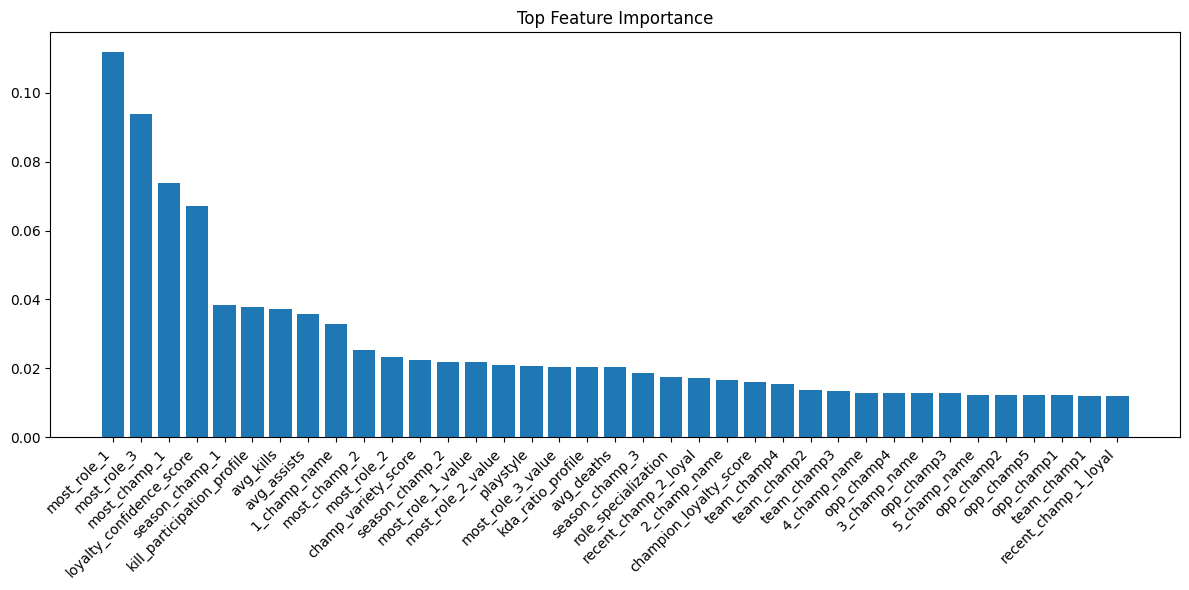

In [62]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(10))

print("\nTop 20 Least Important Features:")
print(feature_importance.tail(10))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Top Feature Importance')
plt.tight_layout()
plt.show()

# # Plot feature importance
# plt.figure(figsize=(12, 6))
# plt.bar(feature_importance.tail(20)['feature'], feature_importance.tail(20)['importance'])
# plt.xticks(rotation=45, ha='right')
# plt.title('Bot 20 Feature Importance')
# plt.tight_layout()
# plt.show()

In [70]:
# Get predictions and probabilities
y_pred = xgb_classifier.predict(X_test)
print("type(X_test): ", type(X_test), "\n X_test: ", X_test, "\n")
print("type(y_pred): ", type(y_pred), "\n y_pred: ", y_pred, "\n")

y_pred_proba = xgb_classifier.predict_proba(X_test)

# Basic accuracy
test_accuracy = xgb_classifier.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Top-k accuracy (since it's champion prediction, top 3-5 might be more relevant)
top_2_accuracy = top_k_accuracy_score(y_test, y_pred_proba, k=2)
top_3_accuracy = top_k_accuracy_score(y_test, y_pred_proba, k=3)
top_5_accuracy = top_k_accuracy_score(y_test, y_pred_proba, k=5)
print(f"Top 2 Accuracy: {top_2_accuracy:.4f}")
print(f"Top 3 Accuracy: {top_3_accuracy:.4f}")
print(f"Top 5 Accuracy: {top_5_accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Save confusion matrix (might be large due to many classes)
cm = confusion_matrix(y_test, y_pred)
np.save('confusion_matrix.npy', cm)
print("\nConfusion matrix saved to 'confusion_matrix.npy'")

# Per-class accuracy
class_accuracies = pd.DataFrame({
    'champion': label_encoder.inverse_transform(range(len(label_encoder.classes_))),
    'accuracy': cm.diagonal() / cm.sum(axis=1)
}).sort_values('accuracy', ascending=False)

print("\nTop 10 Best Predicted Champions:")
print(class_accuracies.head(10))

print("\nBottom 10 Worst Predicted Champions:")
print(class_accuracies.tail(10))

type(X_test):  <class 'pandas.core.frame.DataFrame'> 
 X_test:         team_champ1  team_champ2  team_champ3  team_champ4  opp_champ1  \
4831           128          158            4           99          30   
945             14          150           37           15          40   
5202            56          155          151           72         160   
8847            97           39           58           76         112   
7700            80           30           25          106          56   
...            ...          ...          ...          ...         ...   
8633            52          158           60           43         152   
8451           138          150           37          106          24   
4781            13           51           48           10          56   
6317           110           44           25           46         152   
13115           18          164          166          100         121   

       opp_champ2  opp_champ3  opp_champ4  opp_champ5  avg_

C:\Users\hell0\miniconda3\envs\sMLfinallab\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hell0\miniconda3\envs\sMLfinallab\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hell0\miniconda3\envs\sMLfinallab\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'confusion_matrix' is not defined

Class Distribution:
133    304
21     298
132    293
114    208
142    201
      ... 
76       4
78       4
93       4
15       3
123      3
Name: count, Length: 151, dtype: int64

Imbalance Ratio: 101.33333333333333


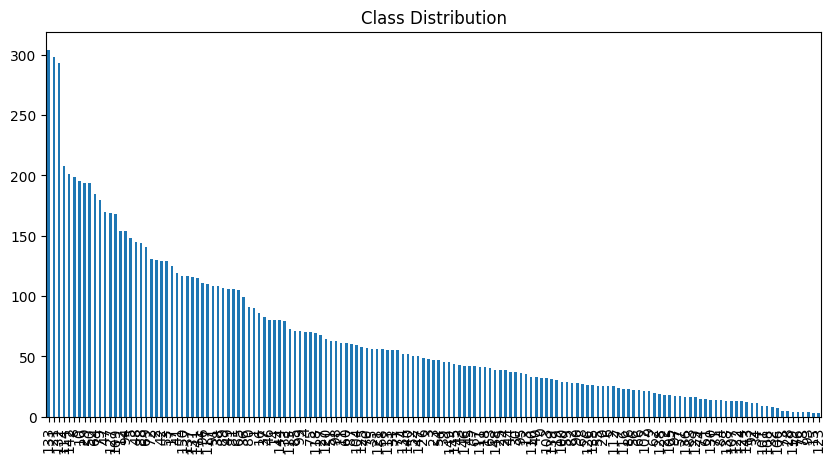

Class Distribution:
133    100
21      99
132     97
114     69
10      65
      ... 
78       2
119      1
123      1
15       1
76       1
Name: count, Length: 151, dtype: int64

Imbalance Ratio: 100.0


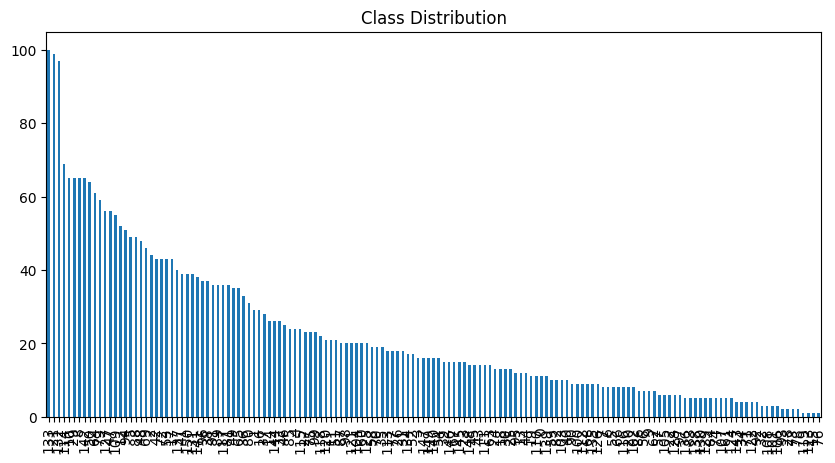

In [44]:
def analyze_class_distribution(y):
    distribution = pd.Series(y).value_counts()
    print("Class Distribution:")
    print(distribution)
    print("\nImbalance Ratio:", 
          distribution.max() / distribution.min())
    
    plt.figure(figsize=(10, 5))
    distribution.plot(kind='bar')
    plt.title('Class Distribution')
    plt.show()
    
    return distribution

# Check distribution
train_dist = analyze_class_distribution(y_train)
val_dist = analyze_class_distribution(y_val)

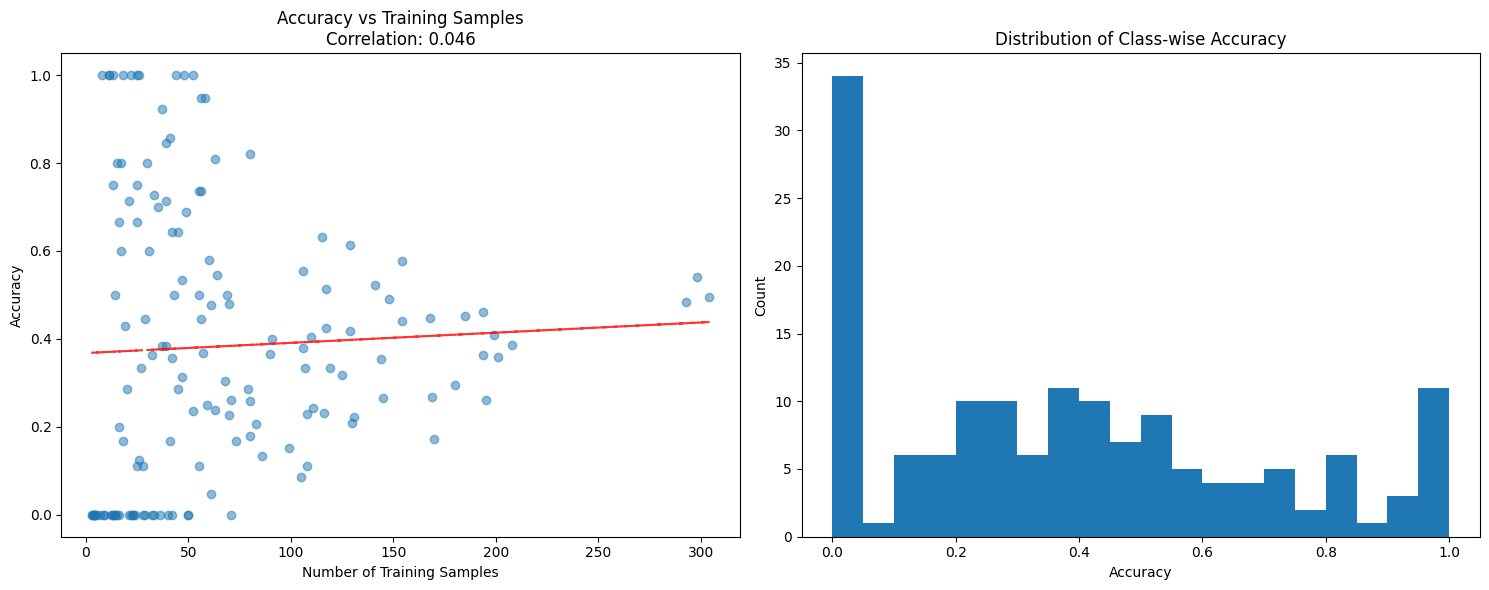


Correlation between training samples and accuracy: 0.045859847974635

Top 10 Most Accurate Champions:
     champion  accuracy  train_samples
55       62.0       1.0             25
92      104.0       1.0             11
32       36.0       1.0              8
122     138.0       1.0             13
34       38.0       1.0             11
126     143.0       1.0             26
105     118.0       1.0             18
134     152.0       1.0             52
56       63.0       1.0             22
145     164.0       1.0             44

Bottom 10 Least Accurate Champions:
     champion  accuracy  train_samples
100     112.0       0.0             29
101     113.0       0.0              9
52       58.0       0.0             50
106     119.0       0.0              7
107     122.0       0.0             13
108     123.0       0.0              9
110     125.0       0.0             33
116     131.0       0.0             23
28       32.0       0.0              5
0         1.0       0.0             32

A

C:\Users\marth\AppData\Local\Temp\ipykernel_11772\3903092542.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_range_stats = analysis_df.groupby('sample_range').agg({


In [45]:
def analyze_accuracy_distribution_correlation(y_test, y_pred, train_dist, label_encoder):
    """
    Analyzes the relationship between class distribution and prediction accuracy
    
    Parameters:
    - y_test: True labels
    - y_pred: Predicted labels
    - train_dist: Training data distribution
    - label_encoder: Label encoder used for the target variable
    """
    # Calculate per-class accuracy
    cm = confusion_matrix(y_test, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Create DataFrame with class information
    analysis_df = pd.DataFrame({
        'champion': label_encoder.classes_,
        'accuracy': class_accuracies,
        'train_samples': train_dist.reindex(label_encoder.transform(label_encoder.classes_)).values
    }).sort_values('accuracy', ascending=False)
    
    # Calculate correlation
    correlation = analysis_df['accuracy'].corr(analysis_df['train_samples'])
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(analysis_df['train_samples'], analysis_df['accuracy'], alpha=0.5)
    ax1.set_xlabel('Number of Training Samples')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'Accuracy vs Training Samples\nCorrelation: {correlation:.3f}')
    
    # Add trend line
    z = np.polyfit(analysis_df['train_samples'], analysis_df['accuracy'], 1)
    p = np.poly1d(z)
    ax1.plot(analysis_df['train_samples'], p(analysis_df['train_samples']), "r--", alpha=0.8)
    
    # Distribution of accuracies
    ax2.hist(analysis_df['accuracy'], bins=20)
    ax2.set_xlabel('Accuracy')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Class-wise Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nCorrelation between training samples and accuracy:", correlation)
    print("\nTop 10 Most Accurate Champions:")
    print(analysis_df[['champion', 'accuracy', 'train_samples']].head(10))
    
    print("\nBottom 10 Least Accurate Champions:")
    print(analysis_df[['champion', 'accuracy', 'train_samples']].tail(10))
    
    # Group accuracy by sample size ranges
    analysis_df['sample_range'] = pd.qcut(analysis_df['train_samples'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    sample_range_stats = analysis_df.groupby('sample_range').agg({
        'accuracy': ['mean', 'std', 'count'],
        'train_samples': ['min', 'max']
    }).round(3)
    
    print("\nAccuracy Statistics by Sample Size Range:")
    print(sample_range_stats)
    
    return analysis_df

# Use the function
analysis_results = analyze_accuracy_distribution_correlation(
    y_test, 
    y_pred, 
    train_dist, 
    label_encoder
)

# Additional analysis for identifying potential issues
def identify_problematic_classes(analysis_df, threshold_accuracy=0.3, threshold_samples=10):
    """
    Identifies classes that might need attention
    """
    problematic = analysis_df[
        (analysis_df['accuracy'] < threshold_accuracy) & 
        (analysis_df['train_samples'] > threshold_samples)
    ].sort_values('train_samples', ascending=False)
    
    print("\nPotentially Problematic Champions:")
    print("(Low accuracy despite having sufficient training samples)")
    print(problematic[['champion', 'accuracy', 'train_samples']])
    
    return problematic

# Identify problematic classes
problematic_classes = identify_problematic_classes(analysis_results)

# Calculate efficiency score (accuracy per training sample)
analysis_results['efficiency'] = analysis_results['accuracy'] / analysis_results['train_samples']
print("\nMost Efficient Champions (High accuracy with few samples):")
print(analysis_results.nlargest(10, 'efficiency')[['champion', 'accuracy', 'train_samples', 'efficiency']])

In [46]:
# Check for missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    return pd.DataFrame({
        'Missing Count': missing,
        'Missing Percent': missing_pct
    }).sort_values('Missing Count', ascending=False)

missing_stats = check_missing(X_train)
print("Features with missing values:")
print(missing_stats[missing_stats['Missing Count'] > 0])

Features with missing values:
                Missing Count  Missing Percent
most_champ_2              310         3.046983
season_champ_3            256         2.516218
season_champ_2            134         1.317083
season_champ_1            109         1.071358


In [47]:
# Model evaluation
test_accuracy = xgb_classifier.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.3968


In [48]:
def predict_top_3_with_confidence(model, X, y_true, label_encoder, champion_converter):
    """
    Predict top 3 champions with confidence scores and compare with true label
    Returns a DataFrame with true champion, predicted champions and their confidence scores
    """
    # Get probabilities
    proba = model.predict_proba(X)
    
    # Get top 3 indices and probabilities
    top_3_idx = np.argsort(proba, axis=1)[:, -3:][:, ::-1]
    top_3_proba = np.take_along_axis(proba, top_3_idx, axis=1)
    
    # Initialize results DataFrame
    results = pd.DataFrame()
    
    # Add true champion - first get original number then convert to champion name
    true_numbers = label_encoder.inverse_transform(y_true)
    results['True_Champion'] = [champion_converter.num_to_champion(int(num)) for num in true_numbers]
    
    # Process each rank separately
    for i in range(3):
        # Convert indices to original numbers then to champion names
        numbers = label_encoder.inverse_transform(top_3_idx[:, i])
        champions = [champion_converter.num_to_champion(int(num)) for num in numbers]
        probabilities = top_3_proba[:, i]
        
        # Add to results
        results[f'Rank_{i+1}_Champion'] = champions
        results[f'Rank_{i+1}_Confidence'] = probabilities.round(4)
    
    # Add whether top prediction was correct
    results['Correct_Prediction'] = results['True_Champion'] == results['Rank_1_Champion']
    
    return results

In [49]:
champion_converter = ChampionConverter()
test_predictions = predict_top_3_with_confidence(xgb_classifier, X_test.head(), y_test[:5], label_encoder, champion_converter)
print(test_predictions)

  True_Champion Rank_1_Champion  Rank_1_Confidence Rank_2_Champion  \
0         Varus          Ezreal             0.2621            Ashe   
1       Caitlyn         Caitlyn             0.2658            Ashe   
2         Corki           Corki             0.3150            Jhin   
3          Zyra            Zyra             0.3739          Graves   
4         Viego         Lee Sin             0.2362           Viego   

   Rank_2_Confidence Rank_3_Champion  Rank_3_Confidence  Correct_Prediction  
0             0.2043           Varus             0.0924               False  
1             0.1566          Ezreal             0.0959                True  
2             0.1120         Caitlyn             0.0788                True  
3             0.0516         Lee Sin             0.0303                True  
4             0.1489         Skarner             0.0473               False  


In [50]:
# Add statistics
print("\nPrediction Statistics:")
print(f"Correct top predictions: {test_predictions['Correct_Prediction'].sum()} out of {len(test_predictions)}")
print(f"Accuracy: {test_predictions['Correct_Prediction'].mean():.2%}")

# Check if true champion appears in top 3
test_predictions['In_Top_3'] = test_predictions.apply(
    lambda row: row['True_Champion'] in [
        row['Rank_1_Champion'], 
        row['Rank_2_Champion'], 
        row['Rank_3_Champion']
    ], 
    axis=1
)

print(f"True champion in top 3: {test_predictions['In_Top_3'].sum()} out of {len(test_predictions)}")
print(f"Top 3 accuracy: {test_predictions['In_Top_3'].mean():.2%}")


Prediction Statistics:
Correct top predictions: 3 out of 5
Accuracy: 60.00%
True champion in top 3: 5 out of 5
Top 3 accuracy: 100.00%



Confidence Analysis:
Average confidence when correct: 0.3182
Average confidence when incorrect: 0.2492


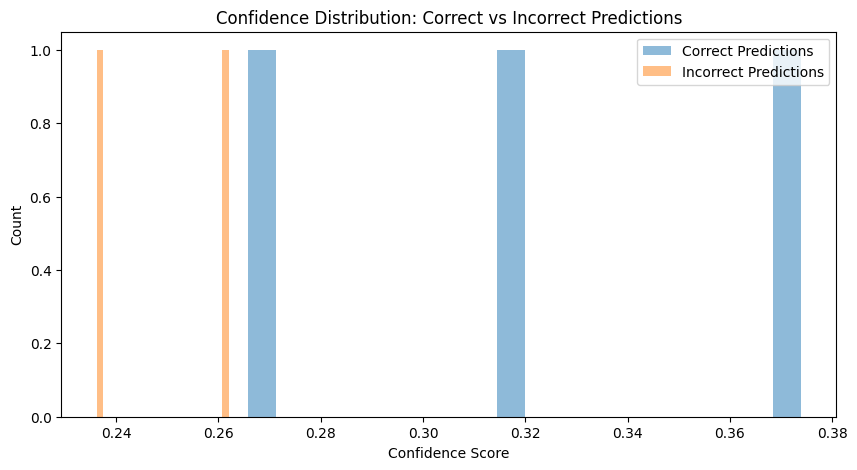

In [52]:
correct_conf = test_predictions[test_predictions['Correct_Prediction']]['Rank_1_Confidence']
incorrect_conf = test_predictions[~test_predictions['Correct_Prediction']]['Rank_1_Confidence']

if len(correct_conf) > 0 and len(incorrect_conf) > 0:
    print("\nConfidence Analysis:")
    print(f"Average confidence when correct: {correct_conf.mean():.4f}")
    print(f"Average confidence when incorrect: {incorrect_conf.mean():.4f}")

# Visualize confidence distribution for correct vs incorrect predictions
plt.figure(figsize=(10, 5))
plt.hist(correct_conf, alpha=0.5, label='Correct Predictions', bins=20)
plt.hist(incorrect_conf, alpha=0.5, label='Incorrect Predictions', bins=20)
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
plt.legend()
plt.show()

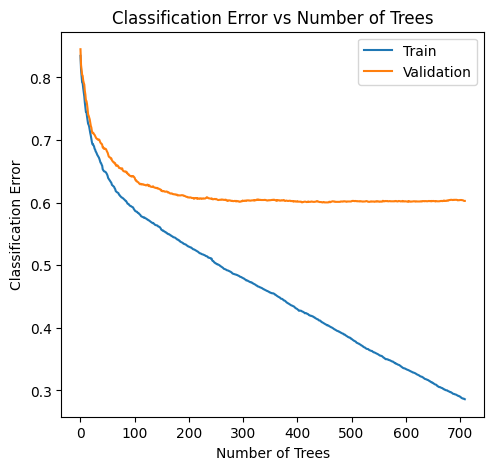

In [54]:
# Plot learning curves
results = xgb_classifier.evals_result()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['merror'], label='Train')
plt.plot(results['validation_1']['merror'], label='Validation')
#plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title('Classification Error vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(results['validation_0']['mlogloss'], label='Train')
# plt.plot(results['validation_1']['mlogloss'], label='Validation')
# #plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
# plt.title('Log Loss vs Number of Trees')
# plt.xlabel('Number of Trees')
# plt.ylabel('Log Loss')
# plt.legend()
# plt.tight_layout()
# plt.show()

C:\Users\marth\AppData\Local\Temp\ipykernel_11772\2025323509.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
C:\Users\marth\AppData\Local\Temp\ipykernel_11772\2025323509.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
C:\Users\marth\AppData\Local\Temp\ipykernel_11772\2025323509.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ado

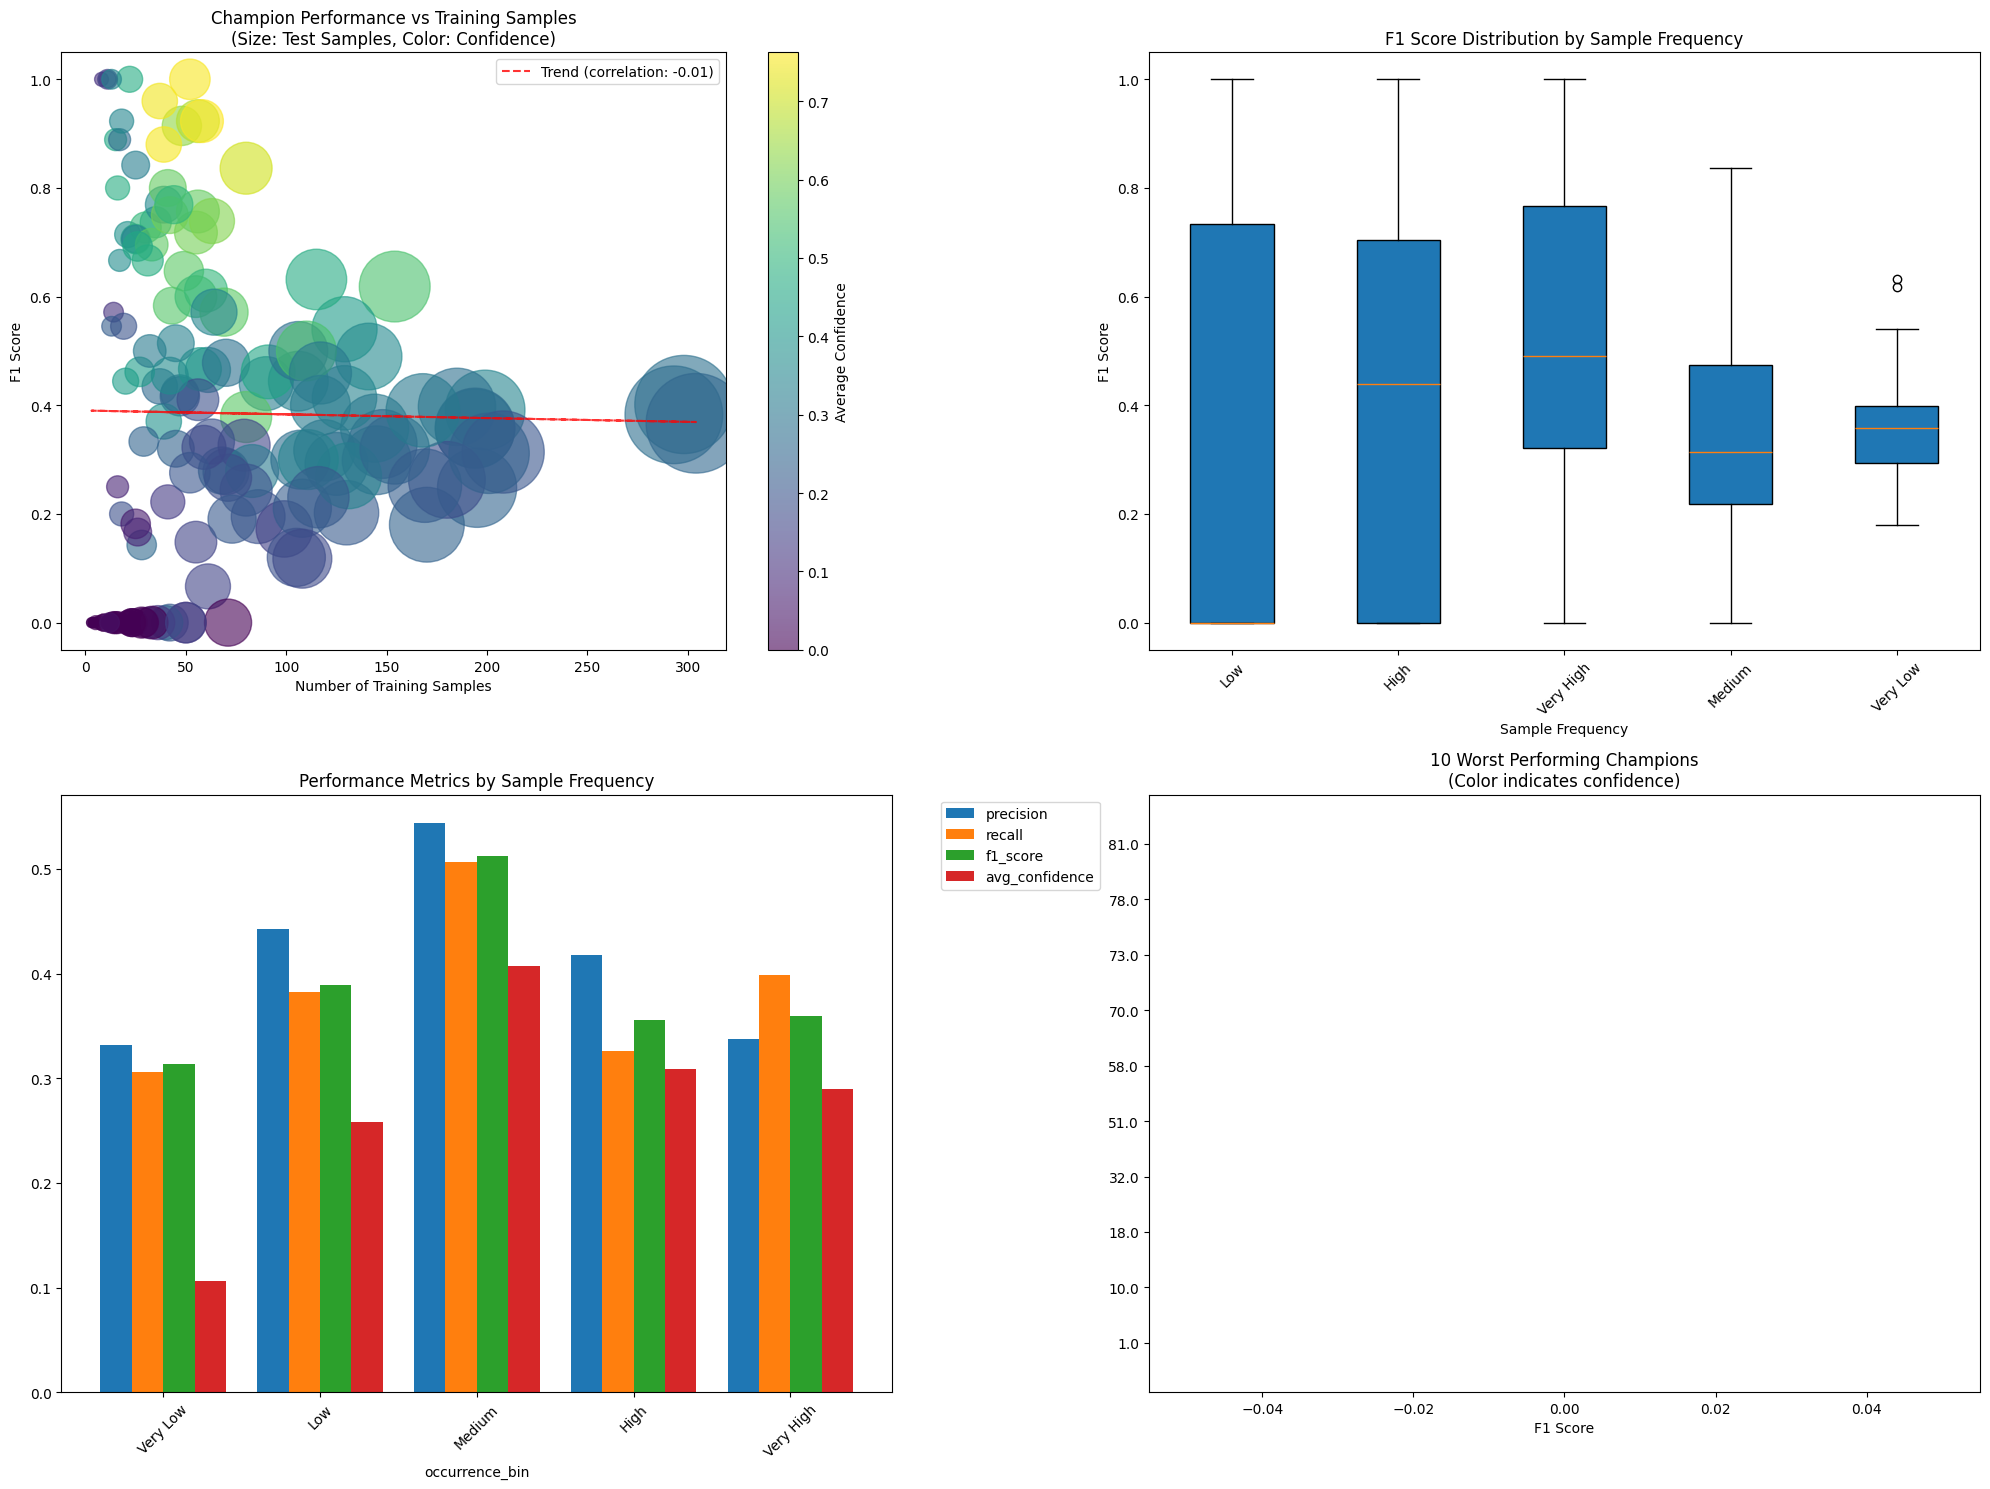


Performance Summary by Sample Frequency:
               training_samples           f1_score                      \
                           mean  min  max     mean    std   min    max   
occurrence_bin                                                           
Very Low                 11.000    3   18    0.314  0.416  0.00  1.000   
Low                      27.467   19   37    0.389  0.344  0.00  1.000   
Medium                   48.133   39   59    0.513  0.307  0.00  1.000   
High                     83.100   60  111    0.356  0.195  0.00  0.836   
Very High               169.067  115  304    0.359  0.109  0.18  0.632   

               precision recall avg_confidence  
                    mean   mean           mean  
occurrence_bin                                  
Very Low           0.332  0.306          0.106  
Low                0.442  0.382          0.258  
Medium             0.544  0.507          0.407  
High               0.418  0.326          0.308  
Very High          0.3

C:\Users\marth\AppData\Local\Temp\ipykernel_11772\2025323509.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = performance_df.groupby('occurrence_bin').agg({


In [55]:
def analyze_champion_performance(y_true, y_pred, y_prob, train_counts):
    """
    Analyze performance metrics for each champion.
    
    Parameters:
    -----------
    y_true : array-like
        True champion labels
    y_pred : array-like
        Predicted champion labels
    y_prob : array-like
        Prediction probabilities for each class
    train_counts : pd.Series
        Number of training samples for each champion
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing performance metrics for each champion
    """
    
    # Initialize results dictionary
    results = {
        'champion': [],
        'training_samples': [],
        'test_samples': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'avg_confidence': []
    }
    
    # Get unique champions
    unique_champions = np.unique(np.concatenate([y_true, y_pred]))
    
    # Calculate metrics for each champion
    for champion in unique_champions:
        # True positives and other metrics
        true_mask = (y_true == champion)
        pred_mask = (y_pred == champion)
        
        # Number of samples
        test_samples = np.sum(true_mask)
        training_samples = train_counts.get(champion, 0)
        
        # Calculate metrics
        tp = np.sum(true_mask & pred_mask)
        fp = np.sum(pred_mask) - tp
        fn = np.sum(true_mask) - tp
        
        # Precision, recall, and F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate average confidence for correct predictions
        champion_idx = np.where(y_pred == champion)[0]
        avg_confidence = np.mean(y_prob[champion_idx, np.where(unique_champions == champion)[0]]) if len(champion_idx) > 0 else 0
        
        # Store results
        results['champion'].append(champion)
        results['training_samples'].append(training_samples)
        results['test_samples'].append(test_samples)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1_score'].append(f1)
        results['avg_confidence'].append(avg_confidence)
    
    # Convert to DataFrame
    performance_df = pd.DataFrame(results)
    
    return performance_df
    
# Get counts and predictions
train_champion_counts = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred)

# Calculate performance metrics
performance_df = analyze_champion_performance(y_test_names, y_pred_names, y_prob, train_champion_counts)

# Add occurrence bins
performance_df['occurrence_bin'] = pd.qcut(performance_df['training_samples'], 
                                         q=5, 
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Create enhanced visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Scatter plot with size based on test samples
plt.subplot(2, 2, 1)
scatter = plt.scatter(performance_df['training_samples'], 
                     performance_df['f1_score'],
                     s=performance_df['test_samples']*50,
                     alpha=0.6,
                     c=performance_df['avg_confidence'],
                     cmap='viridis')
plt.colorbar(scatter, label='Average Confidence')

# Add trend line
z = np.polyfit(performance_df['training_samples'], performance_df['f1_score'], 1)
p = np.poly1d(z)
plt.plot(performance_df['training_samples'], 
         p(performance_df['training_samples']), 
         "r--", 
         alpha=0.8,
         label=f'Trend (correlation: {performance_df["training_samples"].corr(performance_df["f1_score"]):.2f})')

plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Champion Performance vs Training Samples\n(Size: Test Samples, Color: Confidence)')
plt.legend()

# 2. Box plot
plt.subplot(2, 2, 2)
bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
                 labels=performance_df['occurrence_bin'].unique(),
                 patch_artist=True)
plt.xticks(rotation=45)
plt.xlabel('Sample Frequency')
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution by Sample Frequency')

# 3. Performance metrics comparison
plt.subplot(2, 2, 3)
metrics_by_bin = performance_df.groupby('occurrence_bin')[['precision', 'recall', 'f1_score', 'avg_confidence']].mean()
metrics_by_bin.plot(kind='bar', width=0.8, ax=plt.gca())
plt.title('Performance Metrics by Sample Frequency')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Top 10 worst performers with confidence
plt.subplot(2, 2, 4)
worst_performers = performance_df.nsmallest(10, 'f1_score')
bars = plt.barh(range(len(worst_performers)), 
                worst_performers['f1_score'],
                color=plt.cm.RdYlGn(worst_performers['avg_confidence']))
plt.yticks(range(len(worst_performers)), worst_performers['champion'])
plt.xlabel('F1 Score')
plt.title('10 Worst Performing Champions\n(Color indicates confidence)')

plt.tight_layout()
plt.show()

# Print analyses
print("\nPerformance Summary by Sample Frequency:")
summary = performance_df.groupby('occurrence_bin').agg({
    'training_samples': ['mean', 'min', 'max'],
    'f1_score': ['mean', 'std', 'min', 'max'],
    'precision': 'mean',
    'recall': 'mean',
    'avg_confidence': 'mean'
}).round(3)
print(summary)

print("\nDetailed Analysis of Worst Performing Champions:")
print(worst_performers[['champion', 'training_samples', 'test_samples', 
                       'precision', 'recall', 'f1_score', 'avg_confidence']].round(3))

print("\nChampions with High Confidence but Low Performance (Overconfident):")
overconfident = performance_df[
    (performance_df['avg_confidence'] > performance_df['avg_confidence'].median()) &
    (performance_df['f1_score'] < performance_df['f1_score'].median())
].sort_values('avg_confidence', ascending=False)
print(overconfident[['champion', 'training_samples', 'f1_score', 'avg_confidence']].head())

print("\nCorrelation Matrix:")
correlation_matrix = performance_df[['training_samples', 'f1_score', 'avg_confidence']].corr()
print(correlation_matrix.round(3))

# Additional Analysis: Performance vs Sample Size Ratio
performance_df['train_test_ratio'] = performance_df['training_samples'] / performance_df['test_samples']
print("\nPerformance vs Train/Test Ratio Correlation:", 
      performance_df['train_test_ratio'].corr(performance_df['f1_score']).round(3))

# Identify champions needing attention
threshold_samples = performance_df['training_samples'].median()
threshold_f1 = performance_df['f1_score'].median()

needs_attention = performance_df[
    (performance_df['training_samples'] < threshold_samples) &
    (performance_df['f1_score'] < threshold_f1)
].sort_values('f1_score')

print("\nRecommendations for Improvement:")
print(f"Number of champions needing attention: {len(needs_attention)}")
print("\nPriority Champions for Data Collection:")
print(needs_attention[['champion', 'training_samples', 'f1_score', 'avg_confidence']].head())

# Save analysis results
analysis_results = {
    'worst_performers': worst_performers['champion'].tolist(),
    'overconfident_champions': overconfident['champion'].tolist(),
    'needs_attention': needs_attention['champion'].tolist(),
    'correlation_stats': correlation_matrix.to_dict()
}

print("\nSummary Statistics:")
print(f"Average F1 Score: {performance_df['f1_score'].mean():.3f}")
print(f"Median F1 Score: {performance_df['f1_score'].median():.3f}")
print(f"F1 Score Standard Deviation: {performance_df['f1_score'].std():.3f}")

## <span style='color:#ff5f27'>🗄 Save Model</span>

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

In [56]:
import joblib
# Save the model and label encoder
save_dir = os.path.join(current_dir, 'model')
filepath = os.path.join(save_dir, 'champion_predictor.json')
filepath2 = os.path.join(save_dir, 'label_encoder.joblib')
        
xgb_classifier.save_model(filepath)
joblib.dump(label_encoder, filepath2)

['C:\\Users\\marth\\OneDrive - KTH\\[Y1] Period 2\\ID2223 Scalable Machine Learning and Deep Learning\\Projects\\Final Pj\\ID2223-Final-Project\\model\\label_encoder.joblib']